## Question 4H3:

Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.  

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic
approximation:

`hi ∼ Normal(µi, σ)`  
`µi = α + β log(wi)`  
`α ∼ Normal(178, 100)`  
`β ∼ Normal(0, 100)`  
`σ ∼ Uniform(0, 50)`   

where $h_i$ is the height of individual $i$ and $w_i$ is the weight (in kg) of individual $i$. The function for
computing a natural log in R is just log. Can you interpret the resulting estimates?  

(b) Begin with this plot:

`plot( height ~ weight , data=Howell1 , col=col.alpha(rangi2,0.4) )`  

Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on
the plot: (1) the predicted mean height as a function of weight, (2) the 97% HPDI for the mean, and
(3) the 97% HPDI for predicted heights

In [1]:
# load data
library(rethinking)
data(Howell1)
df <- Howell1

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
# build model without log first
m_4H3_no_log <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * (df$weight - mean(df$weight)),
        a ~ dnorm(178, 100),
        b ~ dnorm(0, 100),
        sigma ~ dunif(0, 50)
        ),
    data=df)
precis(m_4H3_no_log)

,mean,sd,5.5%,94.5%
a,138.264238,0.40069826,137.623845,138.904632
b,1.764296,0.02724814,1.720749,1.807844
sigma,9.345884,0.28333877,8.893054,9.798714


In [3]:
# build model

# get log of weight
log_weight <- log(df$weight)
# get average weight and log
log_mean_weight <- mean(log_weight)

#fit model
m_4H3 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * (log_weight - log_mean_weight),
        a ~ dnorm(178, 100),
        b ~ dnorm(0, 100),
        sigma ~ dunif(0, 50)
        ),
    data=df)



In [4]:
# examine model (remember that weight is still logged!)
precis(m_4H3)
round(vcov(m_4H3),4)

,mean,sd,5.5%,94.5%
a,138.263644,0.2201454,137.911809,138.615479
b,47.083165,0.3825736,46.471738,47.694591
sigma,5.134642,0.1556637,4.885861,5.383422


,a,b,sigma
a,0.0485,0.0000,0.0000
b,0.0000,0.1464,0.0000
sigma,0.0000,0.0000,0.0242


In [5]:
#log(x) - log(y) == 1
#x == exp(1 + log(y))
# alternatively: log(x) - log(y) = 1 is the same as log(x/y) = 1 which is the same as x/y = e

Can you interpret the resulting estimates?

$a$ has remained (almost exactly) the same, which makes sense, as it is the height we expect when the observed weight is equal to the the mean weight.

$\sigma$ has changed though (this is the variance of the Gaussian distribution for our distribution of height values). $\mu$ has changed (log weight), so this seems to have changed the distribution's variance

The "slope" also changes because we logged weight so the meaning of "one unit" has changed. 

We expect a 47 cm increase in height for a change in weight corresponding to a difference of "one unit" between the log of the mean and the log of the observation, which is the same as multiplying/dividing by $e$. So I'd say that we expect a $\approx$47 cm increase for each $e$-fold change in weight

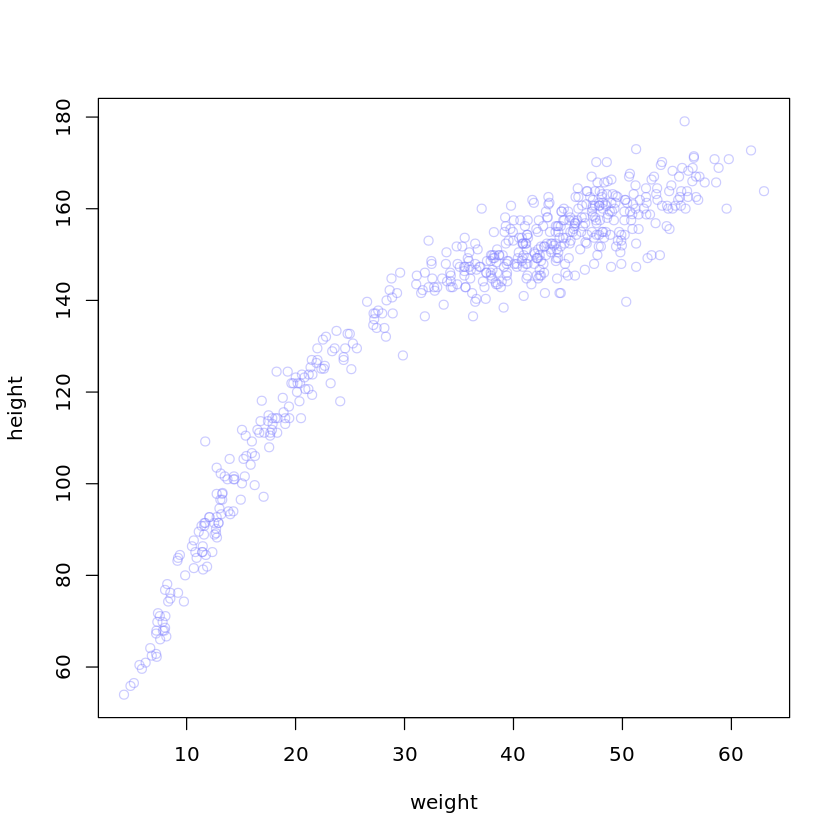

In [6]:
# plot (b: begin with this plot)
plot( height ~ weight , data=df , col=col.alpha(rangi2,0.4) )

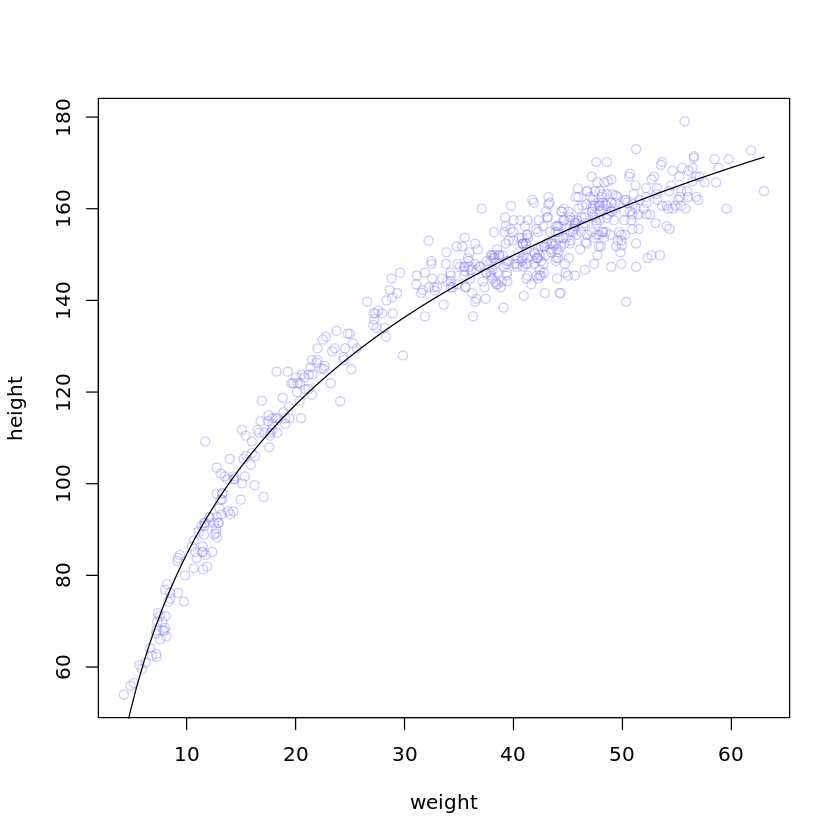

In [6]:
# plot (b: begin with this plot)
plot( height ~ weight , data=df , col=col.alpha(rangi2,0.4) )

# extract 10000 samples from the posterior
post <- extract.samples(object=m_4H3,n=10000)

# get mean of a coefficient
a_map <- mean(post$a)
# get mean of b coefficient
b_map <- mean(post$b)

# plot function relating height and (log) weight
# this is taking our coefficients (from the posterior), mapping it for continuous x (weight) values,
# which we need to log (or our coefficients will be off), taking the difference between the x (weight) and mean (log) weight
curve(a_map + b_map * (log(x) - log_mean_weight), add=TRUE)

#curve(expr, from = NULL, to = NULL, n = 101, add = FALSE,
#      type = "l", xname = "x", xlab = xname, ylab = NULL,
#      log = NULL, xlim = NULL, …)

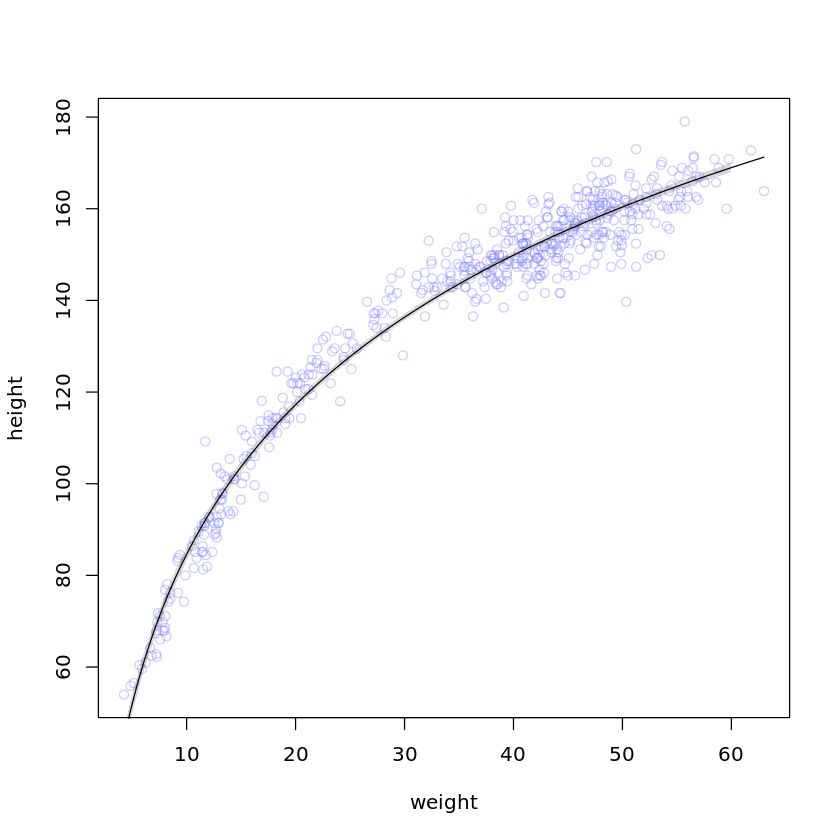

In [8]:
plot( height ~ weight , data=df , col=col.alpha(rangi2,0.4) )
post <- extract.samples(object=m_4H3,n=10000)
a_map <- mean(post$a)
b_map <- mean(post$b)

# add intervals
weight_seq <- log(1:60)
mu <- link( m_4H3 , data=data.frame(log_weight=weight_seq) )

# add curve predicting mean height as function of weight (ignoring distribution around mean at this point)
curve(a_map + b_map * (log(x) - log_mean_weight), add=TRUE)
# alternatively
# mu.mean <- apply( mu , 2 , mean ); lines( exp(weight_seq) , mu.mean )

# add 97% HDPI for mean
mu.HPDI <- apply(mu , 2 , HPDI , prob=0.9999)
shade( mu.HPDI , exp(weight_seq) )

## manual method ##
#post <- extract.samples(m_4H3)
#mu.link <- function(log_weight) post$a + post$b*( log_weight - log_mean_weight)
#weight.seq <- log(seq( from=1 , to=60 , by=1 ))
#mu <- sapply( weight.seq , mu.link )
#mu.mean <- apply( mu , 2 , mean )
#mu.HPDI <- apply( mu , 2 , HPDI , prob=0.97 )


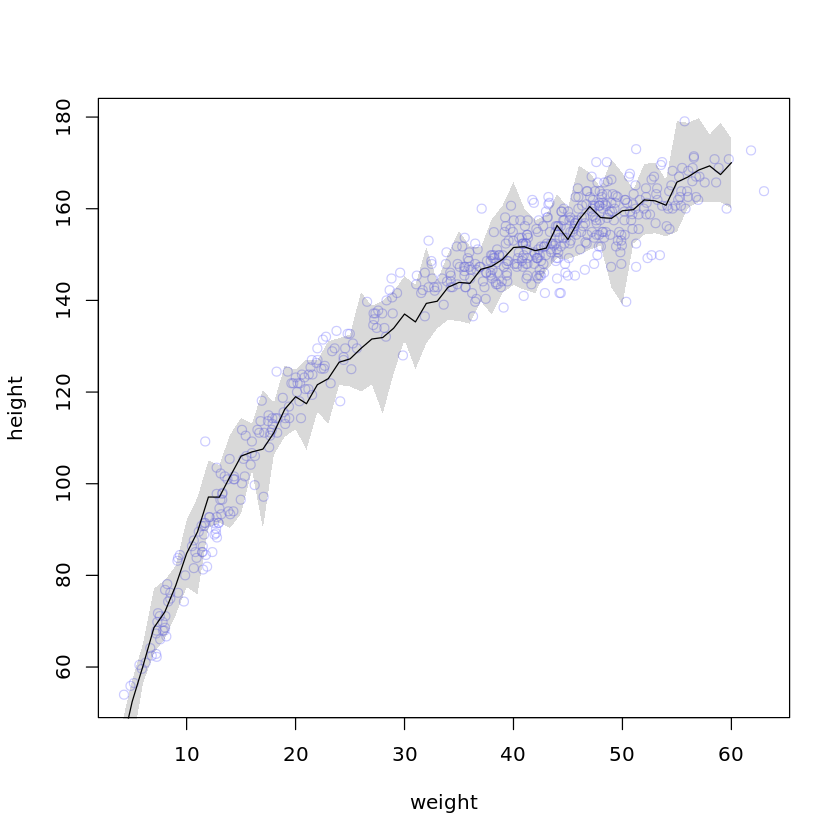

In [13]:
# 97% HPDI for predicted heights

# now we want to account for the distribution (i.e. the Gaussian distribution not just the mean)
# we'll now account for uncertainty in the posterior as well as the uncertainty in the Gaussian
# distribution of heights

# so we want to simulate heights from from a Gaussian with our mean for a given weight but now
# also including the sigma (variance) of the distribution
plot( height ~ weight , data=df , col=col.alpha(rangi2,0.4) )
x_seq <- log(1:60)
# mu now contains simulated heights not distributions of plausible average heights
mu <- sim( m_4H3 , data=list(log_weight=x_seq), n=10)
mu_mean <- apply(mu,2,mean)
mu_ci <- apply(mu,2,HPDI,0.97)
lines( exp(x_seq) , mu_mean )
shade( mu_ci , exp(x_seq) )

## Question HW Q2:

Model the relationship between height (cm) and the natural logarithm of
weight (log-kg): log(weight) . Use the entire Howell1 data frame, all 544
rows, adults and non-adults. Use any model type from Chapter 4 that you
think useful: an ordinary linear regression, a polynomial or a spline. Plot
the posterior predictions against the raw data.

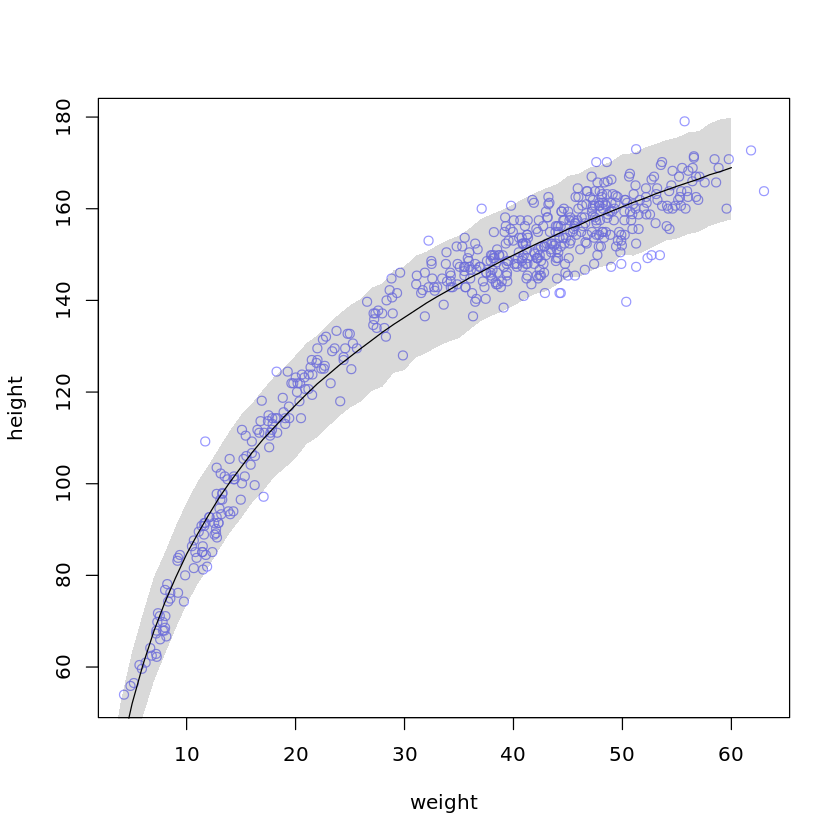

In [10]:
# get log of weight
log_weight <- log(df$weight)
# get average weight and log
log_mean_weight <- mean(log_weight)

#fit linear regression model
m_HW2 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * (log_weight - log_mean_weight),
        a ~ dnorm(178, 100),
        b ~ dnorm(0, 100),
        sigma ~ dunif(0, 50)
        ),
    data=df)

# plot posterior predictions (simulations) on data with 97% HPDI of predicted heights 
plot( height ~ weight , data=df , col=col.alpha(rangi2,0.8) )
x_seq <- log(1:60)
# mu now contains simulated heights not distributions of plausible average heights
mu <- sim( m_HW2 , data=list(log_weight=x_seq), n=10000)
mu_mean <- apply(mu,2,mean)
mu_ci <- apply(mu,2,HPDI,0.97)
lines( exp(x_seq) , mu_mean )
shade( mu_ci , exp(x_seq) )

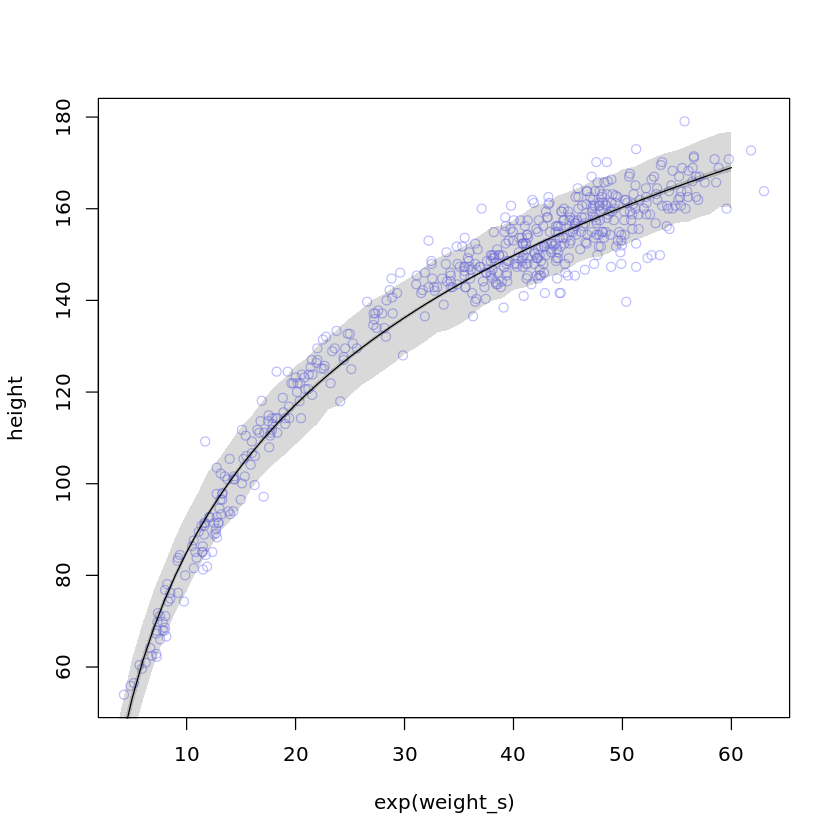

In [15]:
# fit second order polynomial
data(Howell1)
d <- Howell1
d$weight_s <- log(d$weight)
d$weight_s2 <- d$weight_s^2

m4.5 <- quap(
alist(
height ~ dnorm( mu , sigma ) ,
mu <- a + b1*weight_s + b2*weight_s2 ,
a ~ dnorm( 178 , 20 ) ,
b1 ~ dnorm( 0 , 10 ) ,
b2 ~ dnorm( 0 , 10 ) ,
sigma ~ dunif( 0 , 50 )
) ,
data=d )

weight.seq <- log(1:60)
pred_dat <- list( weight_s=(weight.seq) , weight_s2=(weight.seq)^2 )
mu <- link( m4.5 , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )
sim.height <- sim( m4.5 , data=pred_dat )
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )
plot( height ~ exp(weight_s) , d , col=col.alpha(rangi2,0.5) )
lines( exp(weight.seq), mu.mean )
shade( mu.PI , exp(weight.seq) )
shade( height.PI , exp(weight.seq) )

,mean,sd,5.5%,94.5%
a,11.1221803,2.3313187,7.3962827,14.8480780
b1,0.3194742,0.2989992,-0.1583843,0.7973327
b2,19.1394350,0.7372798,17.9611196,20.3177505
b3,-2.4348341,0.1522054,-2.6780876,-2.1915805
sigma,4.9438253,0.1502188,4.7037466,5.1839040


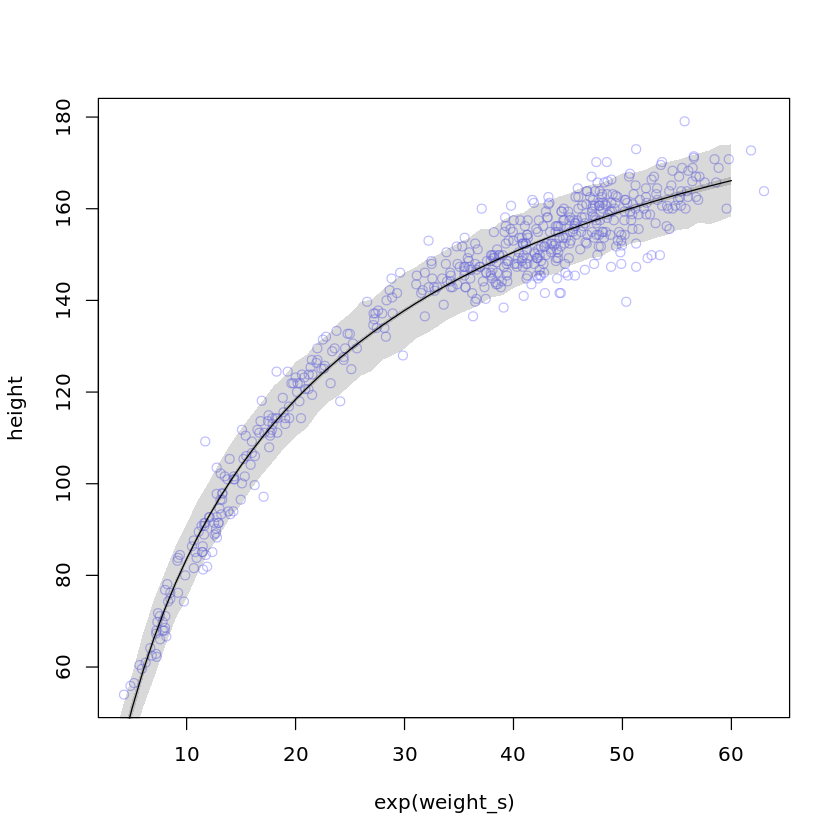

In [16]:
# fit third order polynomial
library(rethinking)
data(Howell1)
d <- Howell1
d$weight_s <- log(d$weight)
d$weight_s2 <- d$weight_s^2
d$weight_s3 <- d$weight_s^3

m3 <- quap(
alist(
height ~ dnorm( mu , sigma ) ,
mu <- a + b1*weight_s + b2*weight_s2 + b3*weight_s3,
a ~ dnorm( 178 , 20 ) ,
b1 ~ dlnorm( 0 , 1 ) ,
b2 ~ dnorm( 0 , 10 ) ,
b3 ~ dnorm( 0 , 10 ) ,
sigma ~ dunif( 0 , 50 )
) ,
data=d )

weight.seq <- log(1:60)
pred_dat <- list( weight_s=(weight.seq) , weight_s2=(weight.seq)^2, weight_s3=(weight.seq)^3 )
mu <- link( m3 , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )
sim.height <- sim( m3 , data=pred_dat )
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )
plot( height ~ exp(weight_s) , d , col=col.alpha(rangi2,0.5) )
lines( exp(weight.seq), mu.mean )
shade( mu.PI , exp(weight.seq) )
shade( height.PI , exp(weight.seq) )

precis(m3)

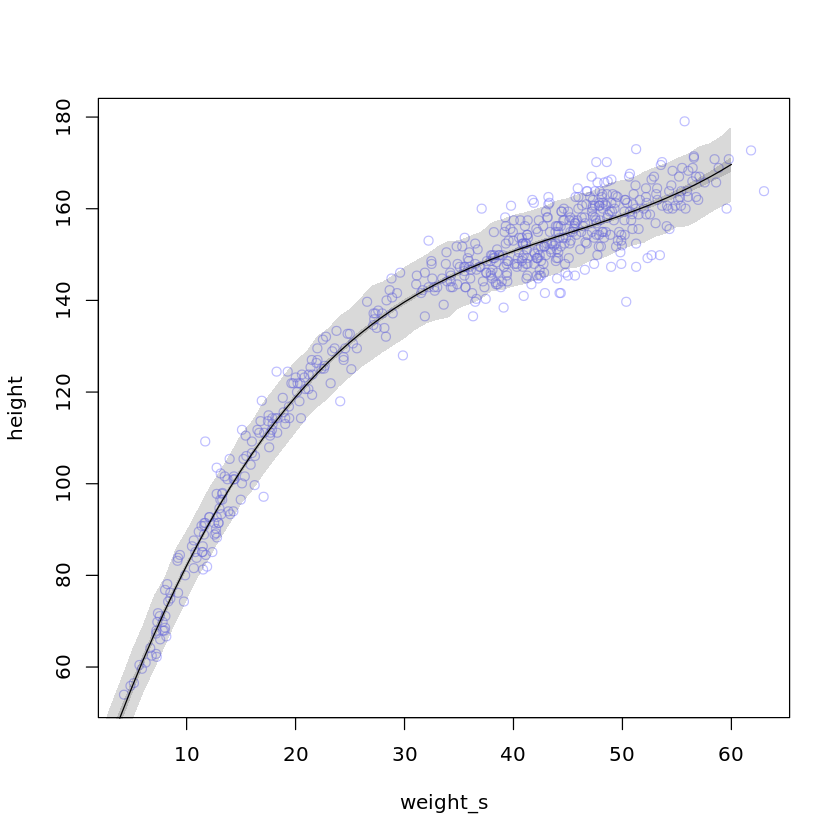

In [17]:
# fit third order polynomial
library(rethinking)
data(Howell1)
d <- Howell1
d$weight_s <- d$weight
d$weight_s2 <- d$weight_s^2
d$weight_s3 <- d$weight_s^3

m3 <- quap(
alist(
height ~ dnorm( mu , sigma ) ,
mu <- a + b1*weight_s + b2*weight_s2 + b3*weight_s3,
a ~ dnorm( 178 , 20 ) ,
b1 ~ dlnorm( 0 , 1 ) ,
b2 ~ dnorm( 0 , 10 ) ,
b3 ~ dnorm( 0 , 10 ) ,
sigma ~ dunif( 0 , 50 )
) ,
data=d )

weight.seq <- 1:60
pred_dat <- list( weight_s=(weight.seq) , weight_s2=(weight.seq)^2, weight_s3=(weight.seq)^3 )
mu <- link( m3 , data=pred_dat )
mu.mean <- apply( mu , 2 , mean )
mu.PI <- apply( mu , 2 , PI , prob=0.89 )
sim.height <- sim( m3 , data=pred_dat )
height.PI <- apply( sim.height , 2 , PI , prob=0.89 )
plot( height ~ weight_s , d , col=col.alpha(rangi2,0.5) )
lines(weight.seq, mu.mean )
shade( mu.PI , weight.seq )
shade( height.PI , weight.seq )